In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
import shap
import time

2024-02-05 13:41:50.527431: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 13:41:51.274146: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-05 13:41:51.277303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 13:41:53.225278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#Dataframe erstellen in dem Ergebnisse gespeichert werden
#Spaltennamen definieren
columns_df = ["Modell", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
#Leeren Dataframe erstellen
ergebnisse = pd.DataFrame(columns=columns_df)

In [3]:
#Datensatz einlesen
Data = pd.read_csv('/home/studio-lab-user/sagemaker-studiolab-notebooks/LC_Data_Clean.csv',low_memory = False)

In [4]:
# Aufteilen der Daten in Features (X) und Zielvariable (y)
X = Data.drop('loan_status', axis=1)
y = Data['loan_status']

In [5]:
#Trainings und Test Datensatz erstellen
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 99) 
#10% der Daten werden zum Testdatensatz

In [6]:
#Daten Scaling da die Spalten unterschiedliche Skalen haben
# Scaler für numerische Variablen initialisieren
scaler = StandardScaler()

###nummerische Trainingsdaten scalen###

#Numerische Variablen auswählen
#nummerische Spaltennamen werden zu einer Liste hinzugefügt
num_cols = ['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 
            'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'acc_now_delinq', 'tot_coll_amt', 
            'acc_open_past_24mths', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 
            'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
            'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
            'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 
            'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 
            'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 
            'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'fico_average']
numerical_data_train = X_train[num_cols] #kategorische Spalten aus Datensatz entfernen
# Kategorische Variablen auswählen
categorical_data_train = X_train.drop(columns = num_cols) #Kategorische Spalten aus dem Trainingsdatensatz auswählen
# Index des ursprünglichen DataFrame speichern
index_train = numerical_data_train.index
# Scaler auf numerische Trainingsdaten anwenden
scaled_data_train = scaler.fit_transform(numerical_data_train)
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_train_scaled = pd.DataFrame(scaled_data_train, columns=num_cols, index= index_train)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_train_scaled = pd.concat([X_train_scaled, categorical_data_train], axis=1)


#nummerische Testdaten scalen 
#Numerische Variablen auswählen
numerical_data_test = X_test[num_cols]
# Kategorische Variablen auswählen
categorical_data_test = X_test.drop(columns = num_cols)
# Index des ursprünglichen DataFrame speichern
index_test = numerical_data_test.index
# Scaler auf numerische Daten anwenden
scaled_data_test = scaler.transform(numerical_data_test) #nicht fit verwenden da auf Trainingsdaten gefittet wurde
# Skalierte numerische Daten in DataFrame zurückkonvertieren
X_test_scaled = pd.DataFrame(scaled_data_test, columns=num_cols, index= index_test)
# Skalierte numerische Daten und kategorische Daten wieder zusammenführen
X_test_scaled = pd.concat([X_test_scaled, categorical_data_test], axis=1)

In [7]:
#sequentielles Modell erstellen
model = Sequential()

#Schichten zum Modell hinzufügen

# Füge eine Eingabeschicht hinzu
model.add(Dense(units=48, input_dim=X_train_scaled.shape[1]))
#Anzahl Units entspricht Anzahl an Neuronen in dieser Schicht
#Für gewöhnlich keine Activation function
#input_dim --> Anzahl an Eingabe Merkmalen die in dieser Schicht erwartet werden (Anzahl an Features)

# Füge versteckte Schichten hinzu
model.add(Dense(units=32, activation='relu'))
#Activation Function tranformiert Werte

# Füge eine Ausgabeschicht hinzu
model.add(Dense(units=1, activation='sigmoid')) #Units = 1 da es nur einen Output geben soll
#Sigmoid transformiert Output in Wert zwischen 0 und 1 

#Modell komplieren und Verlustfunktion und Optimierer angeben
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Erstellen des EarlyStopping-Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

#Modell mit Daten trainieren 
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping])
#Epochs: Zeit in der trainiert wird, höhere Anzahl kann genauere Ergebnisse ausgeben

# Modell speichern
model.save('model.keras') 

#Modell bewerten mit Testdaten
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Testverlust:", loss)
print("Testgenauigkeit:", accuracy)

Epoch 1/100


2024-02-05 13:42:05.719533: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191146368 exceeds 10% of free system memory.


7308/7321 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8052

2024-02-05 13:42:21.395647: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21238848 exceeds 10% of free system memory.


7321/7321 [==============================] - 17s 2ms/step - loss: 0.4602 - accuracy: 0.8052 - val_loss: 0.4599 - val_accuracy: 0.8034
Epoch 2/100
7321/7321 [==============================] - 15s 2ms/step - loss: 0.4531 - accuracy: 0.8070 - val_loss: 0.4555 - val_accuracy: 0.8059
Epoch 3/100
7321/7321 [==============================] - 16s 2ms/step - loss: 0.4517 - accuracy: 0.8073 - val_loss: 0.4541 - val_accuracy: 0.8069
Epoch 4/100
7321/7321 [==============================] - 16s 2ms/step - loss: 0.4506 - accuracy: 0.8075 - val_loss: 0.4547 - val_accuracy: 0.8051
Epoch 5/100
7321/7321 [==============================] - 16s 2ms/step - loss: 0.4497 - accuracy: 0.8080 - val_loss: 0.4532 - val_accuracy: 0.8058
Epoch 6/100
7321/7321 [==============================] - 16s 2ms/step - loss: 0.4493 - accuracy: 0.8084 - val_loss: 0.4528 - val_accuracy: 0.8074
Epoch 7/100
7321/7321 [==============================] - 15s 2ms/step - loss: 0.4486 - accuracy: 0.8083 - val_loss: 0.4551 - val_accurac

In [8]:
#gespeichertes Modell laden
loaded_model = load_model('model.keras')

#Modell bewerten mit Testdaten
loss, accuracy = loaded_model.evaluate(X_test_scaled, y_test)
print("Testverlust:", loss)
print("Testgenauigkeit:", accuracy)

#weitere Testmetriken für Modell 
#Vorhersage mit Modell machen für Testdaten
y_pred0 = loaded_model.predict(X_test_scaled)

#Modellname definieren
modell = "Scaled"

#Schwelle festlegen für Klassen
threshold = 0.5
y_pred = (y_pred0 > threshold).astype(int)

# Precisionberechnen
precision = precision_score(y_test, y_pred)

# Recall berechneb
recall = recall_score(y_test, y_pred)

# F1-Score berechnen
f1 = f1_score(y_test, y_pred)

# AUC-ROC berechnen
roc_auc = roc_auc_score(y_test, y_pred)

# Confusion Matrix ausgeben lassen
conf_matrix = confusion_matrix(y_test, y_pred)

# Accuracy berechnen
accuracy = accuracy_score(y_test, y_pred)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[0] = [modell, accuracy,precision,recall,f1,roc_auc]

#Werte ausgeben
print('Precision:',precision,'\nRecall:',recall,'\nF1:',f1,'\naccuracy:',accuracy,'\nAUC:',roc_auc,'\n',conf_matrix)

814/814 [==============================] - 1s 1ms/step - loss: 0.4523 - accuracy: 0.8055
Testverlust: 0.4523269534111023
Testgenauigkeit: 0.8055171370506287
 82/814 [==>...........................] - ETA: 0s

2024-02-05 13:48:26.012449: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21238848 exceeds 10% of free system memory.


814/814 [==============================] - 1s 1ms/step
Precision: 0.5569620253164557 
Recall: 0.060097560975609754 
F1: 0.10848890454385347 
accuracy: 0.805517135392654 
AUC: 0.5241883776748115 
 [[20658   245]
 [ 4817   308]]


In [9]:
# SMOTE anwenden
smote = SMOTE(random_state=42)#SMOTE algorithmus defineiren
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train) #SMOTE auf Daten fitten

#Klassengewichtung vor SMOTE
unique0, counts0 = np.unique(y_train, return_counts=True) #einzigatige Werte werden gezählt, Anzahl und Werte werden in extra Array gespeichert
class_weights0 = dict(zip(unique0, counts0)) #Dictionary wird erstellt, Anzahl wird Wert zugeteilt
print("Klassengewichte vor SMOTE:", class_weights0)

# Überprüfen der Klassengewichte nach der Anwendung von SMOTE
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_weights = dict(zip(unique, counts))
print("Klassengewichte nach SMOTE:", class_weights)

Klassengewichte vor SMOTE: {0: 188592, 1: 45656}
Klassengewichte nach SMOTE: {0: 188592, 1: 188592}


In [10]:
#sequentielles Modell erstellen
model2 = Sequential()

#Schichten zum Modell hinzufügen

# Füge eine Eingabeschicht hinzu
model2.add(Dense(units=48, input_dim=X_train_resampled.shape[1]))
# Füge versteckte Schichten hinzu
model2.add(Dense(units=32, activation='relu'))
# Füge eine Ausgabeschicht hinzu
model2.add(Dense(units=1, activation='sigmoid'))

#Modell komplieren und Verlustfunktion und Optimierer angeben
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Erstellen des EarlyStopping-Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

#Modell mit Daten trainieren 
model2.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping])

# Modell speichern
model2.save('model2.keras') 

Epoch 1/100


2024-02-05 13:48:43.962140: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 307782144 exceeds 10% of free system memory.


11787/11787 [==============================] - 24s 2ms/step - loss: 0.3490 - accuracy: 0.8403 - val_loss: 0.4634 - val_accuracy: 0.8033
Epoch 2/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3230 - accuracy: 0.8523 - val_loss: 0.4609 - val_accuracy: 0.8044
Epoch 3/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3208 - accuracy: 0.8534 - val_loss: 0.4617 - val_accuracy: 0.8041
Epoch 4/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3194 - accuracy: 0.8537 - val_loss: 0.4615 - val_accuracy: 0.8032
Epoch 5/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3187 - accuracy: 0.8540 - val_loss: 0.4626 - val_accuracy: 0.8006
Epoch 6/100
11787/11787 [==============================] - 24s 2ms/step - loss: 0.3185 - accuracy: 0.8543 - val_loss: 0.4632 - val_accuracy: 0.8026
Epoch 7/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3182 - accuracy: 0.8541 - val_loss: 0.4664

In [11]:
#gespeichertes Modell laden
loaded_model2 = load_model('model2.keras')

#Modell bewerten mit Testdaten
loss2, accuracy2 = loaded_model2.evaluate(X_test_scaled, y_test)
print("Testverlust:", loss2)
print("Testgenauigkeit:", accuracy2)

#weitere Testmetriken für Modell 

#Modellname definieren
modell2 = "Scaled + SMOTE"

y_pred02 = loaded_model2.predict(X_test_scaled)

threshold = 0.5
y_pred2 = (y_pred02 > threshold).astype(int)

# Precision
precision2 = precision_score(y_test, y_pred2)

# Recall
recall2 = recall_score(y_test, y_pred2)

# F1-Score
f12 = f1_score(y_test, y_pred2)

# AUC-ROC
roc_auc2 = roc_auc_score(y_test, y_pred2)

# Confusion Matrix
conf_matrix2 = confusion_matrix(y_test, y_pred2)

# Accuracy
accuracy2 = accuracy_score(y_test, y_pred2)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[1] = [modell2, accuracy2,precision2,recall2,f12,roc_auc2]  ##ändern auf 1

print('Precision:',precision2,'\nRecall:',recall2,'\nF1:',f12,'\naccuracy:',accuracy2,'\nAUC:',roc_auc2,'\n',conf_matrix2)

2024-02-05 14:00:00.798816: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21238848 exceeds 10% of free system memory.


814/814 [==============================] - 2s 2ms/step - loss: 0.4579 - accuracy: 0.8046
Testverlust: 0.45785829424858093
Testgenauigkeit: 0.8046334981918335
814/814 [==============================] - 1s 2ms/step
Precision: 0.5242718446601942 
Recall: 0.08429268292682927 
F1: 0.14523449319213316 
accuracy: 0.8046334716459198 
AUC: 0.5327696969626253 
 [[20511   392]
 [ 4693   432]]


In [12]:
#sequentielles Modell erstellen
model3 = Sequential()

#Schichten zum Modell hinzufügen

# Füge eine Eingabeschicht hinzu
model3.add(Dense(units=48, input_dim=X_train_resampled.shape[1]))
# Füge versteckte Schichten hinzu
model3.add(Dense(units=32))
model3.add(LeakyReLU(alpha=0.01))  # Hinzufügen der LeakyReLU Aktivierung mit einem Alpha von 0.01
# Füge eine Ausgabeschicht hinzu
model3.add(Dense(units=1, activation='sigmoid'))

#Modell komplieren und Verlustfunktion und Optimierer angeben
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Erstellen des EarlyStopping-Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

#Modell mit Daten trainieren 
model3.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping])

# Modell speichern
model3.save('model3.keras') 

Epoch 1/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3515 - accuracy: 0.8395 - val_loss: 0.4679 - val_accuracy: 0.8041
Epoch 2/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3229 - accuracy: 0.8521 - val_loss: 0.4623 - val_accuracy: 0.8035
Epoch 3/100
11787/11787 [==============================] - 25s 2ms/step - loss: 0.3201 - accuracy: 0.8536 - val_loss: 0.4618 - val_accuracy: 0.8035
Epoch 4/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3197 - accuracy: 0.8536 - val_loss: 0.4598 - val_accuracy: 0.8057
Epoch 5/100
11787/11787 [==============================] - 22s 2ms/step - loss: 0.3188 - accuracy: 0.8543 - val_loss: 0.4605 - val_accuracy: 0.8029
Epoch 6/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3180 - accuracy: 0.8545 - val_loss: 0.4615 - val_accuracy: 0.8031
Epoch 7/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3175 - accuracy: 0.8544 - val_

In [13]:
#gespeichertes Modell laden
loaded_model3 = load_model('model3.keras')

#Modell bewerten mit Testdaten
loss3, accuracy3 = loaded_model3.evaluate(X_test_scaled, y_test)
print("Testverlust:", loss3)
print("Testgenauigkeit:", accuracy3)

#weitere Testmetriken für Modell 

#Modellname definieren
modell3 = "Activation Function:\nLeaky ReLU"

y_pred03 = loaded_model3.predict(X_test_scaled)

threshold = 0.5
y_pred3 = (y_pred03 > threshold).astype(int)

# Precision
precision3 = precision_score(y_test, y_pred3)

# Recall
recall3 = recall_score(y_test, y_pred3)

# F1-Score
f13 = f1_score(y_test, y_pred3)

# AUC-ROC
roc_auc3 = roc_auc_score(y_test, y_pred3)

# Accuracy
accuracy3 = accuracy_score(y_test, y_pred3)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[2] = [modell3, accuracy3,precision3,recall3,f13,roc_auc3] 

print('Precision:',precision3,'\nRecall:',recall3,'\nF1:',f13,'\naccuracy:',accuracy3,'\nAUC:',roc_auc3,'\n')

814/814 [==============================] - 1s 1ms/step - loss: 0.4598 - accuracy: 0.8057
Testverlust: 0.45977678894996643
Testgenauigkeit: 0.8056707978248596
814/814 [==============================] - 1s 1ms/step
Precision: 0.555008210180624 
Recall: 0.06595121951219513 
F1: 0.11789326822462504 
accuracy: 0.80567081604426 
AUC: 0.5264932866445825 



In [14]:
#Startzeit messen
start=time.time()

#sequentielles Modell erstellen
model4 = Sequential()

#Schichten zum Modell hinzufügen

# Füge eine Eingabeschicht hinzu
model4.add(Dense(units=48, input_dim=X_train_resampled.shape[1]))
# Füge erste versteckte Schicht hinzu
model4.add(Dense(units=32, activation='relu'))
# Füge zweite versteckte Schicht hinzu
model4.add(Dense(units=32, activation='relu'))
# Füge eine Ausgabeschicht hinzu
model4.add(Dense(units=1, activation='sigmoid'))

#Modell komplieren und Verlustfunktion und Optimierer angeben
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Erstellen des EarlyStopping-Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

#Modell mit Daten trainieren 
model4.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test),callbacks=[early_stopping])

#Endzeit messen
end_time = time.time()

# Modell speichern
model4.save('model4.keras') 

Epoch 1/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3445 - accuracy: 0.8418 - val_loss: 0.4613 - val_accuracy: 0.8051
Epoch 2/100
11787/11787 [==============================] - 23s 2ms/step - loss: 0.3235 - accuracy: 0.8522 - val_loss: 0.4639 - val_accuracy: 0.8018
Epoch 3/100
11787/11787 [==============================] - 24s 2ms/step - loss: 0.3208 - accuracy: 0.8529 - val_loss: 0.4590 - val_accuracy: 0.8049
Epoch 4/100
11787/11787 [==============================] - 25s 2ms/step - loss: 0.3199 - accuracy: 0.8533 - val_loss: 0.4665 - val_accuracy: 0.7986
Epoch 5/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3187 - accuracy: 0.8540 - val_loss: 0.4666 - val_accuracy: 0.7969
Epoch 6/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3184 - accuracy: 0.8542 - val_loss: 0.4632 - val_accuracy: 0.7995
Epoch 7/100
11787/11787 [==============================] - 26s 2ms/step - loss: 0.3177 - accuracy: 0.8545 - val_

In [15]:
#gespeichertes Modell laden
loaded_model4 = load_model('model4.keras')

#Modell bewerten mit Testdaten
loss4, accuracy4 = loaded_model4.evaluate(X_test_scaled, y_test)
print("Testverlust:", loss4)
print("Testgenauigkeit:", accuracy4)

#weitere Testmetriken für Modell 

#Modellname definieren
modell4 = "Zwei Hidden Layers"

y_pred04 = loaded_model4.predict(X_test_scaled)

threshold = 0.5
y_pred4 = (y_pred04 > threshold).astype(int)

# Precision
precision4 = precision_score(y_test, y_pred4)

# Recall
recall4 = recall_score(y_test, y_pred4)

# F1-Score
f14 = f1_score(y_test, y_pred4)

# AUC-ROC
roc_auc4 = roc_auc_score(y_test, y_pred4)

# Accuracy
accuracy4 = accuracy_score(y_test, y_pred4)

#Ergebnisse zum Dataframe hinzufügen
ergebnisse.loc[3] = [modell4, accuracy4,precision4,recall4,f14,roc_auc4] 

print('Precision:',precision4,'\nRecall:',recall4,'\nF1:',f14,'\naccuracy:',accuracy4,'\nAUC:',roc_auc4,'\n')

#Gesamtzeit berechnen
elapsed_time = end_time - start
print('Gesamtrechenzeit :', elapsed_time, 'Sekunden')

814/814 [==============================] - 2s 2ms/step - loss: 0.4590 - accuracy: 0.8049
Testverlust: 0.45903629064559937
Testgenauigkeit: 0.8049408197402954
814/814 [==============================] - 1s 1ms/step
Precision: 0.5459770114942529 
Recall: 0.055609756097560976 
F1: 0.10093855144324419 
accuracy: 0.8049408329491317 
AUC: 0.52213583532764 

Gesamtrechenzeit : 328.600252866745 Sekunden


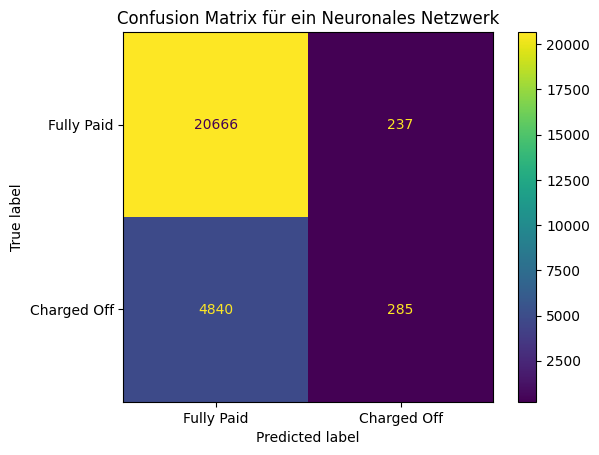

In [16]:
#Confusion Matrix für Modell 4 erstellen
unique_labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred4, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fully Paid", "Charged Off"])
disp.plot()
plt.title('Confusion Matrix für ein Neuronales Netzwerk')
#plt.savefig('/home/studio-lab-user/sagemaker-studiolab-notebooks/nn_cm.jpg')
plt.show()

AUC:  0.52213583532764


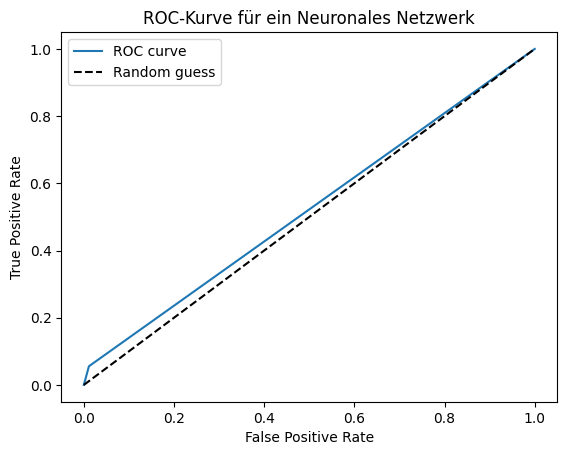

In [17]:
#ROC Kurve für Modell 4 plotten

#false positves und true positives berechnen
fpr, tpr, thresholds = roc_curve(y_test, y_pred4)

#auc berechnen
auc = roc_auc_score(y_test, y_pred4)

print('AUC: ', auc)

# ROC-Kurve plotten
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve für ein Neuronales Netzwerk')
plt.legend()
#plt.savefig('/home/studio-lab-user/sagemaker-studiolab-notebooks/nn_roc.jpg')
plt.show()


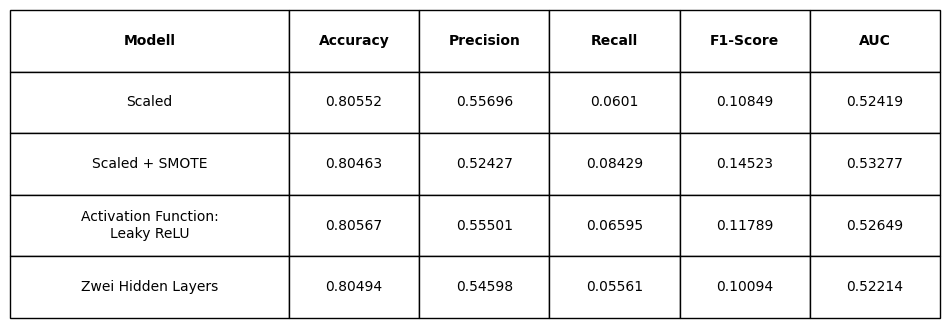

In [18]:
# Numerische Spalten auf 5 Nachkommastellen begrenzen
numerical_cols = ergebnisse.select_dtypes(include=['float64']).columns
ergebnisse[numerical_cols] = ergebnisse[numerical_cols].round(5)

# Tabelle erstellen
fig, ax = plt.subplots(figsize=(12, 4))  # Figur und Achsen erstellen
ax.axis('off')  # Achsen ausschalten

# Spaltenbreiten festlegen
col_widths = [0.3] + [0.14 for _ in range(ergebnisse.shape[1] - 1)]

# Tabellendiagramm erstellen
table = ax.table(cellText=ergebnisse.values, colLabels=ergebnisse.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1], colWidths=col_widths)

# Überschriften fett drucken
table.auto_set_font_size(False)
table.set_fontsize(10)  # Schriftgröße anpassen, falls gewünscht
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold')  # Überschrift fett drucken

plt.show()

## Modell erklären mit SHAP Values

4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6875/6875 [==============================] - 11s 2ms/step


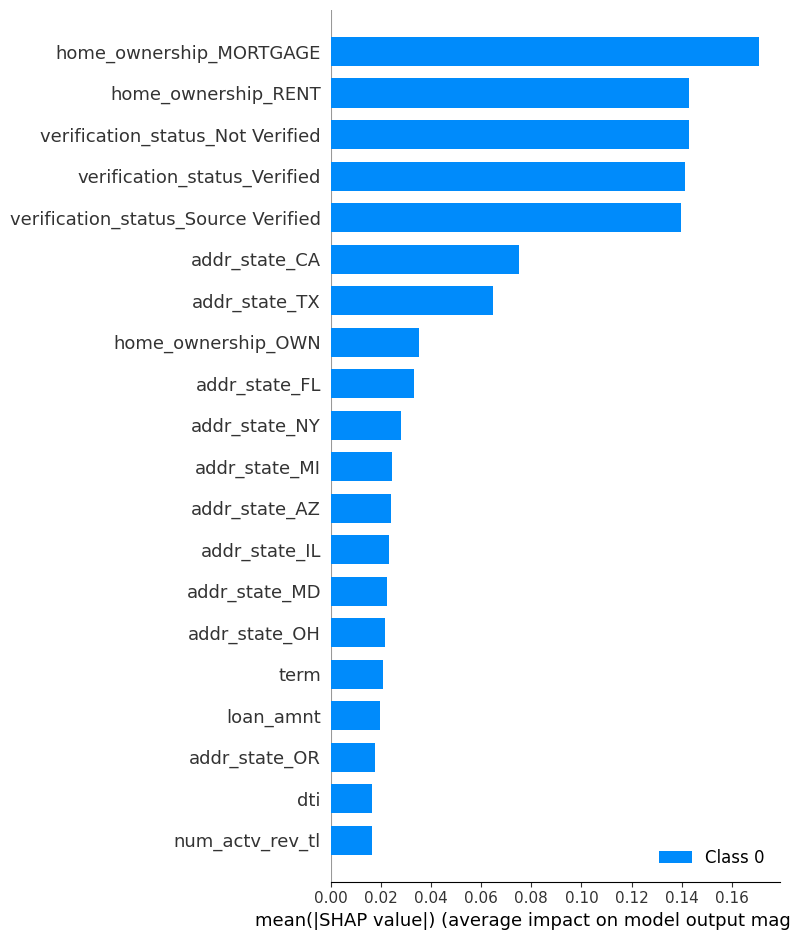

In [19]:
# Annahme: X_train_resampled enthält Ihre Trainingsdaten
background = X_train_resampled.iloc[np.random.choice(X_train_resampled.shape[0], 100, replace=False)]

# KernelExplainer-Objekt erstellen
explainer = shap.KernelExplainer(model4.predict, background)

# SHAP-Werte berechnen
shap_values = explainer.shap_values(background)

# Größe des Plots anpassen
plt.figure(figsize=(15, 8))

# SHAP-Werte im Summary-Plot für beide Klassen anzeigen
shap.summary_plot(shap_values, background, show=False)

# Plot anzeigen
plt.show()

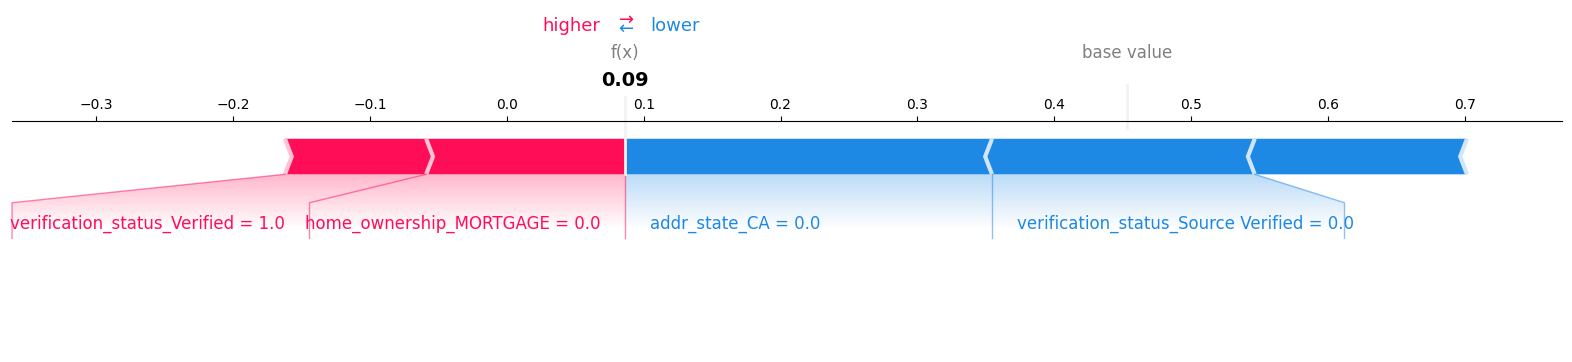

In [25]:
#Shap Values für eien Beobachtung mit Klasse 0 auswählen
shap_values_instance = shap_values[0][4, :]

# Betrag der SHAP-Werte berechnen
abs_shap_values = np.abs(shap_values_instance)

#Indizes nach dem Betrag in absteigender Reihenfolge sortieren
sorted_indices = np.argsort(abs_shap_values)[::-1]

#Top-5-Indizes auswählen
top5_indices = sorted_indices[:5]

#Force Plot nur für die Top-5-Features erstellen
shap.plots.force(explainer.expected_value[0], shap_values_instance[top5_indices], background.iloc[0, top5_indices], matplotlib=True)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


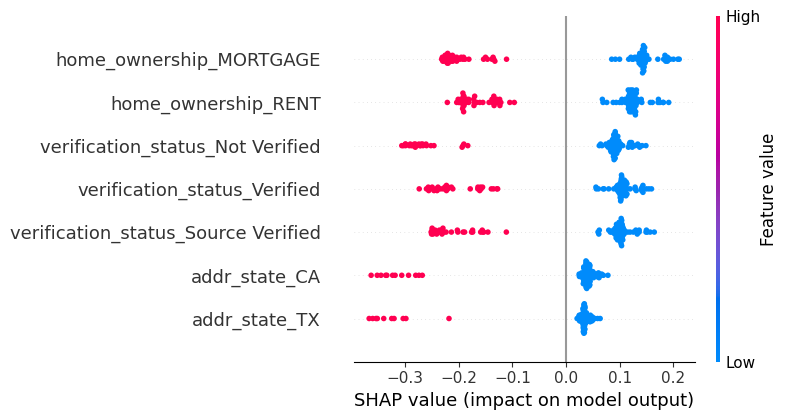

In [21]:
#Punktediagramm erstellen für Klasse 0 mit den Top 7 features
shap.summary_plot(shap_values[0], background,max_display=7)